# LSTM Steps

1. Get Data
2. Data Preparation - Transform - Data wrangling/muging
3. LSTM - model - hyper parameter searching
4. validation and test 
5. using the model


# 1. Get Data

## Use or Download the Stocks Data

In this example, we will use a timeseries data "stockdata.csv". You can get fresh copy of this data by using: https://github.com/sada-narayanappa/COMP4449/blob/master/capstone/stock_prediction1/getstocksdata.py

This sample data is used throughout this example to demonstate LSTM



In [3]:
f='data/stockdata.csv'
df=pd.read_csv(f)
df

,timestamp,MSFT_open,MSFT_high,MSFT_low,MSFT_close,MSFT_volume,601288.SS_open,601288.SS_high,601288.SS_low,601288.SS_close,...,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_volume,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume
0,2010-07-15,25.500,25.5900,24.98,25.51,56934700.0,2.74,2.74,2.69,2.70,...,248.23,256.97,247.30,251.45,29459500.0,129.87,130.9200,129.55,130.72,6186800.0
1,2010-07-16,25.510,25.6400,24.88,24.89,65064800.0,2.70,2.70,2.68,2.69,...,253.18,254.97,248.41,249.90,37137800.0,129.96,130.1500,127.85,128.03,7002900.0
2,2010-07-19,24.960,25.3000,24.91,25.23,38181800.0,2.68,2.71,2.68,2.71,...,249.88,249.88,239.60,245.58,36588500.0,128.67,130.3800,128.37,129.79,8388600.0
3,2010-07-20,24.860,25.4800,24.70,25.48,45530700.0,2.70,2.71,2.69,2.71,...,242.90,252.90,240.01,251.89,38391100.0,122.97,126.5600,122.93,126.55,16337400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2801,2021-08-31,304.420,304.5000,301.50,301.88,26285338.0,2.92,2.96,2.91,2.96,...,152.66,152.80,151.29,151.83,86453117.0,139.54,140.9400,138.95,140.34,4235101.0
2802,2021-09-01,302.865,305.1900,301.49,301.83,18983826.0,2.95,2.99,2.95,2.99,...,152.83,154.98,152.34,152.51,80313711.0,139.98,140.0699,139.19,139.30,2474544.0
2803,2021-09-02,302.200,303.3602,300.18,301.15,16290545.0,2.98,2.99,2.97,2.98,...,153.87,154.72,152.40,153.65,71171317.0,139.72,140.0500,139.03,140.01,2715659.0
2804,2021-09-03,300.990,302.6000,300.26,301.14,14751610.0,2.99,3.01,2.97,3.01,...,153.76,154.63,153.09,154.30,57866066.0,139.68,140.4700,139.30,139.58,1924215.0


# 2. Data Prepration

There are several utilities that will help you to prepare the data.
You can stack these selections and transformations using utilities provided.

Few data transformations you may condider doing are:

1. Data Columns Selection - dfselect (input: data frame, include_columns, exclude_columns)
2. Drop non-numeric columns
3. drop columns with only one unique value
4. Detect time correlated sensors (because they have no information)
5. Adding columns - add_diff (input: columns ) - this will add first order difference 
6. Add moving average value
7. Add correlation coefficient b/w pair of columns
8. Add one hot encoding of a column
9. separate inputs and outs and scale columns - default is to standard scaler for all columns


In [18]:
sys.path.append("/opt/utils")
import gen.dataprep
from gen.dataprep import *
# We will just use few columns
columns = 'timestamp MSFT_close GLD_close GOOGL_close AAPL_close IBM_close'.split()
df = pd.read_csv(f)
df = dfselect        (df, columns)
df = drop_nonnumerics(df)
df = drop_unique     (df, 1 )
df = drop_time_correlated(df)

predict = ['MSFT_close']
dfo = df[predict]
dfi = df[[c for c in df.columns[1:] if c not in predict ]]

X, scalerX = data_scale(dfi)
y, scalery = data_scale(dfo)

+Good: no nonnumeric columns
+Good: Nothing to drop
+Good: No time correlated columns having corr-coeffient >= 0.95


# LSTM Model

In [42]:
import utils1;
import ccallbacks
import lfit

# Step 1 - read the files from configuration
conf, unnormdf, normeddf, inputs, ouputs    = lfit.getConf("exp/myconfig")
modelFile, history, lookahead, trng1, valg1, valg2, X, y = lfit.getGenerators(conf, normeddf, inputs, ouputs)


#Getting Configuration from exp/myconfig

    TrnFile: /opt/SCHAS/NNBook/notebooks/NNetworks/LSTM/exp/daily_MSFT_Norm_0.csv,
    I/P    : ['open', 'high', 'low', 'close'] ...
    O/P    : ['open___diff1'] ...
    Shape  : (5032, 7)
    trnCnt : 4528"
    


4982 6.407848474054845e-09: 6.407848474054845e-09 <= 0.0022709693294018507


<Figure size 1152x360 with 0 Axes>

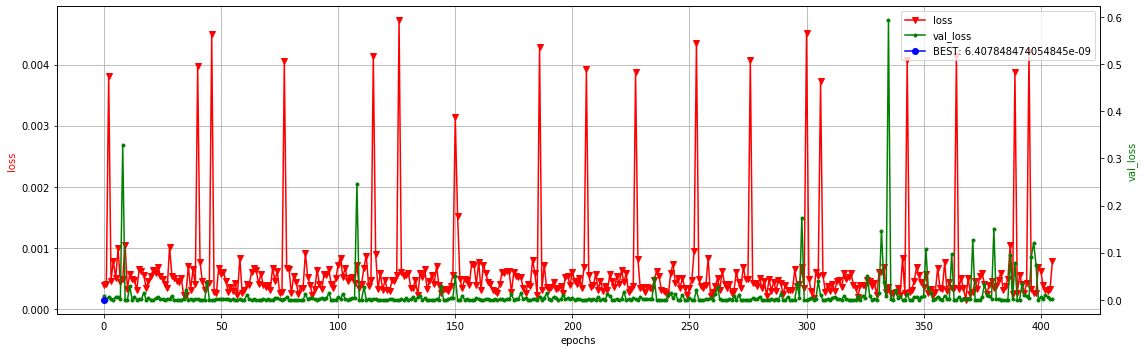

In [25]:
#Lets keep the model if we already constructed it - A wierdness in Jupyter
if "model" not in globals():
    model, mcpoint = lfit.getModel(conf)

lfit.fit(model, trng1, valg1, mcpoint, ep=3)
mcpoint.save_ext()

import sys
sys.path.append(".")
sys.path.append("gen")
import ccallbacks
print(len(valg2), mcpoint.best)
mcpoint.drawLosses()

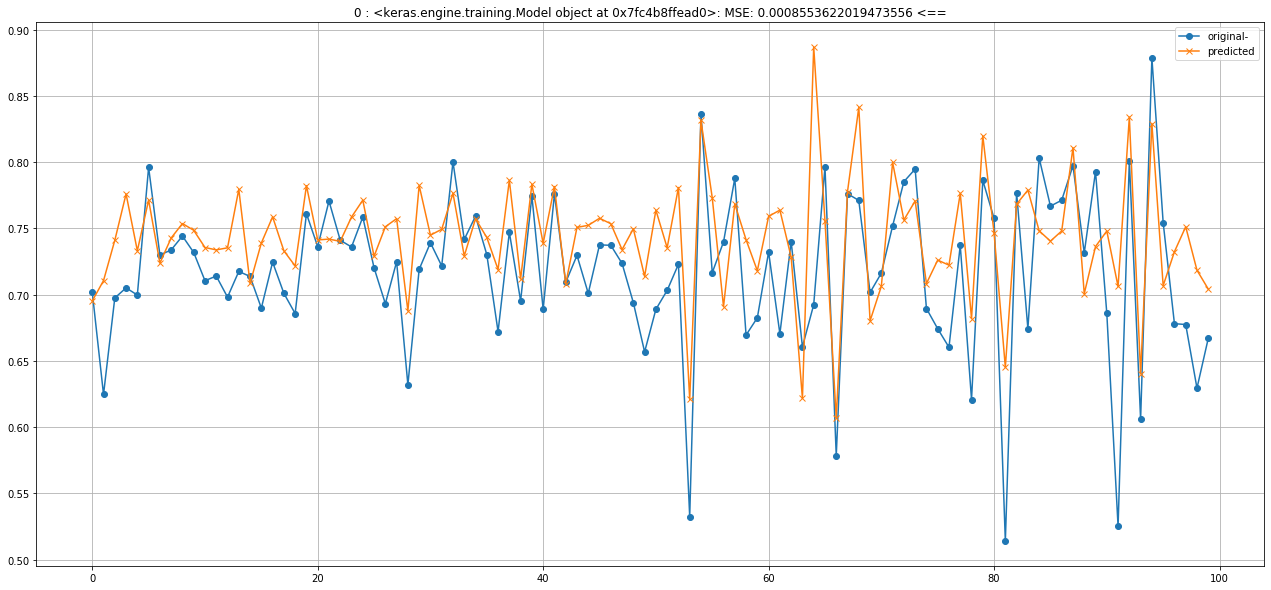

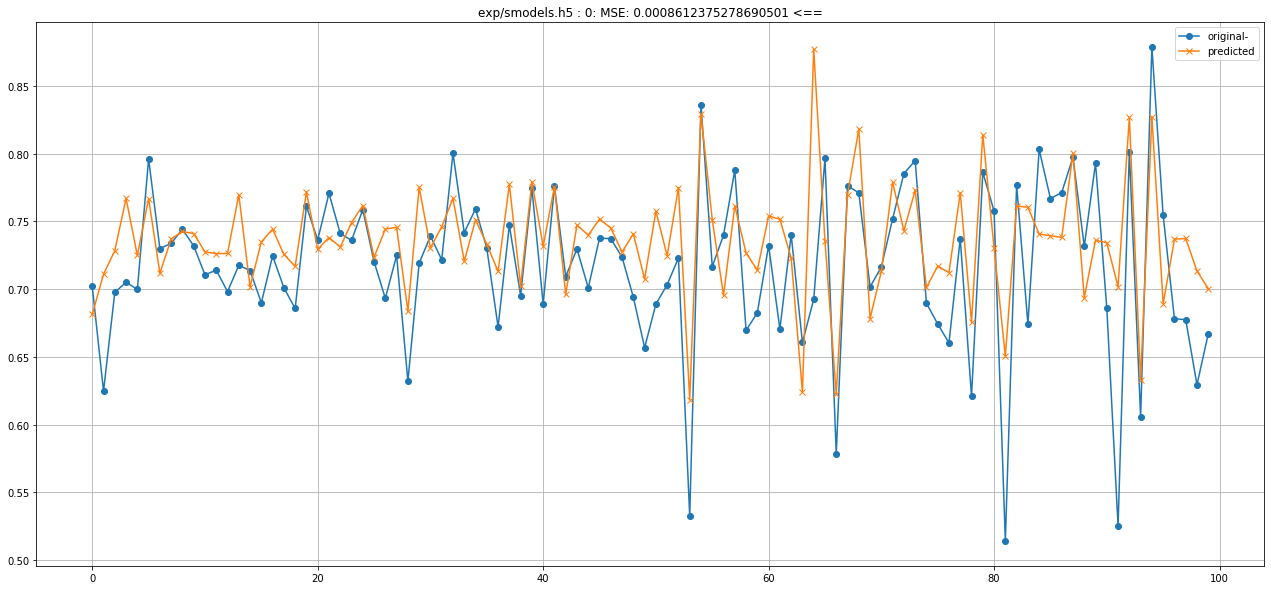

In [26]:
yy1, yh1,mse1 = ccallbacks.plot1(0, valg2, model, idx=0, n=-400, howmany=100);
plt.show()
yy, yh, mse = ccallbacks.plot1(mcpoint.filepath, valg2, 0, idx=0, n=-400, howmany=100);


# Move this to PY file

Getting Original column for: 'open' 


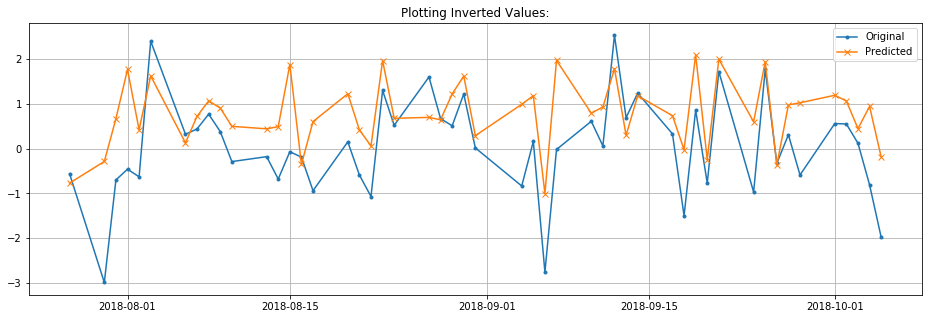

In [44]:
import utils2

#yh = ccallbacks.predict(modelFile, valg2, model)
yidf = utils2.reconstructOrig(conf, unnormdf, yh, ouputs)

utils2.plotInverted(conf, yh, unnormdf, s=-400, howmany=50)

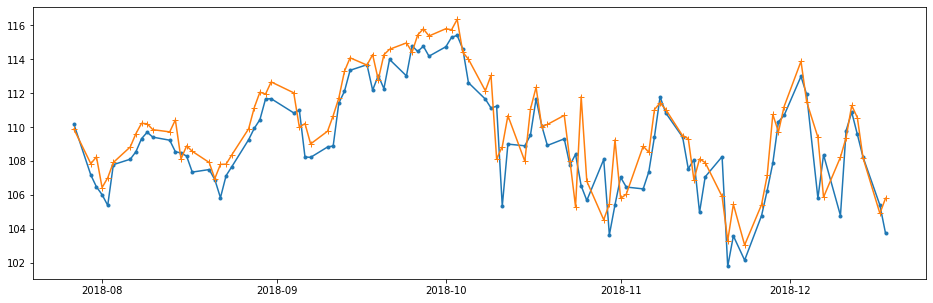

In [45]:
#Lets plot the original values and see how it looks
yidf

s=-400
e=s+100
col="open"
x = pd.to_datetime(unnormdf[unnormdf.columns[0]][s:e])
plt.plot(x, unnormdf[col][s:e], marker='.', label="Original")
plt.plot(x, yidf[col][s:e], marker='+', label="Predicted")
